In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision
import torchvision.models as models
from torchsummary import summary

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
batch_size = 64
train_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616]),
    ])

val_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616])
    ])

train_set = CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=train_transform
)

val_set = CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=val_transform
)

trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

testloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4,
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [3]:
import timm

model = timm.create_model("convnext_small", pretrained=False)

model.head.fc = nn.Linear(in_features=768, out_features=10)

/home/server-96gb-ailab/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model = model.to(device)

In [5]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 96, 8, 8]           4,704
       LayerNorm2d-2             [-1, 96, 8, 8]             192
          Identity-3             [-1, 96, 8, 8]               0
            Conv2d-4             [-1, 96, 8, 8]           4,800
         LayerNorm-5             [-1, 8, 8, 96]             192
            Linear-6            [-1, 8, 8, 384]          37,248
              GELU-7            [-1, 8, 8, 384]               0
           Dropout-8            [-1, 8, 8, 384]               0
          Identity-9            [-1, 8, 8, 384]               0
           Linear-10             [-1, 8, 8, 96]          36,960
          Dropout-11             [-1, 8, 8, 96]               0
              Mlp-12             [-1, 8, 8, 96]               0
         Identity-13             [-1, 96, 8, 8]               0
         Identity-14             [-1, 9

# Train

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [7]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [8]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 50

In [9]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{(epoch + 1):3}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [  1/ 50] 	 Loss: 1.67079     Accuracy: 39.32% 	 Test Loss: 1.41576     Test Accuracy: 48.37%
Epoch [  2/ 50] 	 Loss: 1.19421     Accuracy: 56.54% 	 Test Loss: 1.13154     Test Accuracy: 60.02%
Epoch [  3/ 50] 	 Loss: 0.89928     Accuracy: 68.21% 	 Test Loss: 0.83474     Test Accuracy: 70.77%
Epoch [  4/ 50] 	 Loss: 0.72146     Accuracy: 74.31% 	 Test Loss: 0.76090     Test Accuracy: 73.71%
Epoch [  5/ 50] 	 Loss: 0.58605     Accuracy: 79.32% 	 Test Loss: 0.68474     Test Accuracy: 76.49%
Epoch [  6/ 50] 	 Loss: 0.46782     Accuracy: 83.45% 	 Test Loss: 0.71163     Test Accuracy: 76.59%
Epoch [  7/ 50] 	 Loss: 0.36153     Accuracy: 87.24% 	 Test Loss: 0.64035     Test Accuracy: 79.34%
Epoch [  8/ 50] 	 Loss: 0.26656     Accuracy: 90.43% 	 Test Loss: 0.72191     Test Accuracy: 79.25%
Epoch [  9/ 50] 	 Loss: 0.19480     Accuracy: 93.15% 	 Test Loss: 0.75215     Test Accuracy: 79.22%
Epoch [ 10/ 50] 	 Loss: 0.15133     Accuracy: 94.60% 	 Test Loss: 0.75368     Test Accuracy: 79.47%


In [10]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%")


Best epoch: 49 with test accuracy: 82.23%


# Plot results

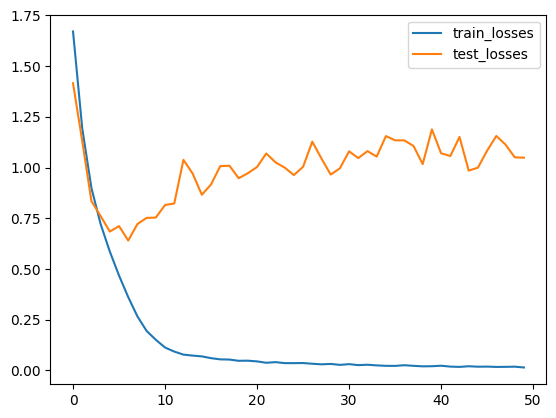

In [11]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

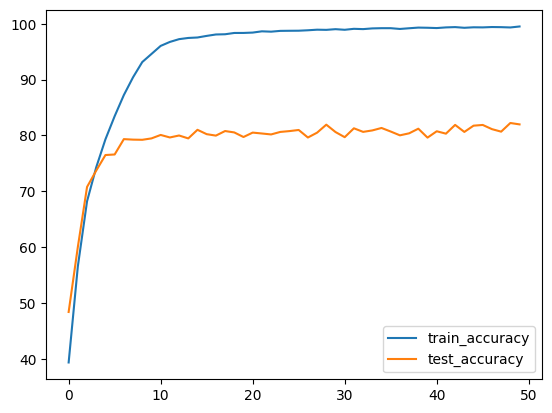

In [12]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()